## Libnames

In [5]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook')
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.datasets import load_boston
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn.linear_model import LassoCV, Lasso, RidgeCV, Ridge
from sklearn.model_selection import StratifiedKFold, KFold, LeaveOneOut
from sklearn.linear_model import LinearRegression

## Funções  - data prep

In [6]:
def standard_scaler_manual (data) :
    data2 = (data - data.mean())/data.std()
    return data2


def fit_transform_with_function (data, function, sklearn):
    scaler = function
    
    if sklearn == 'True':
        scaler = function
        data_transformed = scaler.fit_transform(data)
        data_transformed2 = pd.DataFrame(data_transformed, columns = data.columns, index = data.index)
        
    else:
        data_transformed2 = data.apply(function)
        
    return scaler, data_transformed2

#X_train.apply(standard_scaler_manual)


def transform_with_function (data, scaler, sklearn):
    
    if sklearn == 'True':
        data_transformed = scaler.transform(data)
        data_transformed2 = pd.DataFrame(data_transformed, columns = data.columns, index = data.index)
    
    else:
        data_transformed2 = data.apply(scaler)
    
        
    
    return data_transformed2



## Funções Modelagem

In [7]:
def split_train_test_data (data, name_target, test_size, random_state):
    
    X_all = data.drop([name_target], axis = 1)
    y_all = data[name_target]

    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = test_size ,random_state = random_state)

    print "Training set has {} samples and {} features.".format(X_train.shape[0], X_train.shape[1])
    print "Testing set has {} samples and {} features.".format(X_test.shape[0], X_test.shape[1])
    
    X_train.reset_index(drop=True, inplace = True)
    X_test.reset_index(drop=True, inplace = True)
    y_train.reset_index(drop=True, inplace = True)
    y_test.reset_index(drop=True, inplace = True)
    
    return X_train, X_test, y_train, y_test

    
def grid_search_model (x, y, clf, parameters, scorer, cv, verbose):
    grid_obj = GridSearchCV(clf, parameters, scoring = scorer, cv =  cv, verbose= verbose)
    start = time()
    grid_fit = grid_obj.fit(x, y)
    end = time()
    print "Best score:" , grid_fit.best_score_
    print "Best parameters:" , grid_fit.best_params_
    print "Find best parameterers in {:.4f} seconds.".format(end - start) 
    return grid_fit.best_estimator_


def model_reg_cv (model, X, y, cv):

    first = True

    for train_index, test_index in cv.split(X):
        #print(train_index)
        model2 = model.fit(X.iloc[train_index],y[train_index])
        
        pred_train = model2.predict(X.iloc[train_index])
        pred_test = model2.predict(X.iloc[test_index])

        y_train = y[train_index]
        y_test = y[test_index]
        
        mse_treino = mean_squared_error(y_train, pred_train)
        mse_teste = mean_squared_error(y_test, pred_test)
        
        mae_treino = mean_absolute_error(y_train, pred_train)
        mae_teste = mean_absolute_error(y_test, pred_test)
        
        r2_treino = r2_score (y_train, pred_train)
        r2_teste = r2_score (y_test, pred_test)

        resultados_aux = {
        "MSE: 1. Treino" : [mse_treino] ,
        "MSE: 2. Teste" : [mse_teste],
        "MAE: 1. Treino" : [mae_treino],
        "MAE: 2. Teste" : [mae_teste],
        "r2: 1. Treino" : [r2_treino],
        "r2: 2. Teste" : [r2_teste]
        }

        resultados_aux = pd.DataFrame(resultados_aux)

        if first == True:
            results_folds = resultados_aux
            first = False
        else:
            results_folds = pd.concat([results_folds, resultados_aux], axis = 0)    

    results_folds.index = range(cv.get_n_splits(X))
    results_mean = np.transpose(pd.DataFrame(results_folds.mean(), columns=['mean']))
    
    results_folds = pd.concat([results_folds, results_mean], axis = 0)

    return results_folds



def model_reg_holdout (reg, X_train, y_train, X_test, y_test):
    reg.fit(X_train, y_train)
    
    pred_train = reg.predict(X_train)
    pred_test = reg.predict(X_test)

    #coeficientes
    #print "Number of coefficients:", len(reg.coef_)
    #print "Estimated intercept coefficient:", reg.intercept_
   
    #print '\n'
    
    #coefficients = pd.DataFrame(zip(X_train.columns, reg.coef_), columns = ['features', 'coefficients'])
    #coefficients.sort_values(by = 'coefficients', ascending = False, inplace=True)
    #print coefficients
    
    mse_train = mean_squared_error(y_train, pred_train)
    mse_test = mean_squared_error(y_test, pred_test)
    
    mae_train = mean_absolute_error(y_train, pred_train)
    mae_test = mean_absolute_error(y_test, pred_test)
    
    r2_train = r2_score (y_train, pred_train)
    r2_test = r2_score (y_test, pred_test)
    
    resultados = {
    
    "2. Teste" : [mse_test, mae_test, r2_test],
    "1. Treino" : [mse_train, mae_train, r2_train]
    }
    
    resultados = pd.DataFrame(resultados)
    resultados.index = ['MSE','MAE', 'R2']
    return resultados


def plot_graphs ( X_train, y_train, X_test, y_test):
    plt.scatter(y_train, lm.predict(X_train))
    plt.xlabel("Prices: $Y_i$")
    plt.ylabel("Predicted prices: $\hat{Y}_i$")
    plt.title("Train Data - Prices vs Predicted Prices $Y_i$ vs $\hat{Y}_i$")
    plt.show()

    plt.scatter(y_test, lm.predict(X_test))
    plt.xlabel("Prices: $Y_i$")
    plt.ylabel("Predicted prices: $\hat{Y}_i$")
    plt.title("Test Data - Prices vs Predicted Prices $Y_i$ vs $\hat{Y}_i$")
    plt.show()
    
def plot_residuals(X_train, y_train, X_test, y_test):
    plt.scatter(lm.predict(X_train), lm.predict(X_train)-y_train, c='b', s=40, alpha = 0.5)
    plt.scatter(lm.predict(X_test), lm.predict(X_test)-y_test, c='g', s=40, alpha = 0.5)
    plt.hlines(y=0, xmin = 0, xmax = 50)
    plt.title('Residual Plot using training (blue) and test (green) data')
    plt.ylabel('Residuals')
    plt.show()
    

### Dados

In [8]:
boston = load_boston()

In [9]:
print boston.keys()
print boston.data.shape
print boston.feature_names
#boston.DESCR

['data', 'feature_names', 'DESCR', 'target']
(506L, 13L)
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [10]:
data = pd.DataFrame(boston.data)
data.columns = boston.feature_names

In [11]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [12]:
data['PRICE'] = boston.target

In [13]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [14]:
X_train, X_test, y_train, y_test = split_train_test_data(data, 'PRICE', test_size = 0.20 ,random_state = 791231)

Training set has 404 samples and 13 features.
Testing set has 102 samples and 13 features.


### data prep - normalização dos dados - usando a biblioteca e usando uma função específica

In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
scaler = MinMaxScaler()


In [16]:
scaler, X_train_final = fit_transform_with_function(X_train,  StandardScaler(), 'True')
X_train_final.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.399699,-0.484437,-0.172623,-0.288288,-0.085823,-0.517664,0.861626,-0.667972,-0.389419,0.152949,-0.302769,0.405984,0.489518
1,-0.397756,-0.484437,-0.382086,-0.288288,-0.318306,-0.166590,0.757293,-0.635883,-0.505355,-0.133371,1.129208,0.379747,-0.047046
2,-0.406474,-0.484437,-1.033588,-0.288288,-0.404410,0.791261,0.196056,-0.401240,-0.505355,-0.658292,-0.857082,0.363262,-0.795192
3,0.139224,-0.484437,0.996036,-0.288288,0.491078,0.957122,-0.048586,-0.582764,1.697429,1.548762,0.805859,0.170666,-0.139700
4,-0.390968,0.467094,-0.772121,-0.288288,-1.084637,-0.085042,0.368744,2.038800,-0.273483,-0.455482,0.297738,0.187616,-0.348517


In [17]:
X_test_final = transform_with_function(X_test, scaler, 'True')
X_test_final.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.122900,-0.484437,1.209833,-0.288288,2.703967,-1.403642,0.901200,-0.960861,-0.505355,-0.020036,-1.734746,-3.150135,0.479837
1,-0.411133,-0.484437,-0.597327,-0.288288,-0.757440,0.184483,0.357951,0.572744,-0.853162,-0.980403,-0.302769,0.428622,-0.488189
2,0.562595,-0.484437,0.996036,-0.288288,1.343514,-0.485874,0.408319,-0.465846,1.697429,1.548762,0.805859,-4.138424,0.590469
3,-0.403214,0.056205,-0.481761,-0.288288,-0.283864,-0.550837,-1.077522,0.802403,-0.505355,-0.568817,-1.503782,0.354323,0.420373
4,1.293269,-0.484437,0.996036,-0.288288,1.231578,-1.945457,1.117061,-1.030594,1.697429,1.548762,0.805859,0.150234,2.482270


# Modelagem

Objetivos:
Criar funções de:

#### 1. Validação cruzada com grid search (aplicável pra Lasso, Ridge ou outras funcoes que variam ou não parâmetros)
    
##### Nome função: grid_search_model (x, y, clf, parameters, scorer, cv)

X -> base_explicativas

y -> base_resposta

clf -> modelo sklearn

parameters -> parâmetros pra variar tune

scorer -> métrica utilizada para avaliar melhores parâmetros

cv -> objeto de cross-validation (KFold, StratifiedKFold, etc)
 
A função exporta: melhor modelo
Print: melhor score, melhor parâmetro, tempo.


####  2. Validação cruzada sem grid search (aplicável pra qualquer modelo) - exporta métricas (mae, mse,r2) para cada fold e respectivas médias (dentro das partições)

##### Nome função: model_reg_cv (model, X, y, cv):

X -> base_explicativas

y -> base_resposta

model -> modelo sklearn

cv -> objeto de cross-validation (KFold, StratifiedKFold, etc)

A função exporta: treino e teste das partições do cv com mae, mse, r2
Print - coeficientes

#### 3. HoldOut - resultados e fit do modelo em uma base treino específica e aplicação na base teste com  métricas

##### Nome função: model_reg_holdout (reg, X_train, y_train, X_test, y_test)

X_train -> base_explicativas - treino

y_train -> base_resposta - treino

X_test -> base_explicativas - teste

y_test -> base_resposta - teste

reg -> modelo sklearn

A função exporta: treino e teste  com mae, mse, r2


## Regressão Linear

###  CV

In [18]:
cv_kfold = KFold(5, random_state=12)
cv_loo = LeaveOneOut()

In [19]:
lm = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)
model_reg_cv(lm, X_train_final, y_train, cv = cv_loo)

,MAE: 1. Treino,MAE: 2. Teste,MSE: 1. Treino,MSE: 2. Teste,r2: 1. Treino,r2: 2. Teste
0,3.315327,2.325271,22.313974,5.406884,0.741433,0.0
1,3.316660,1.299535,22.323046,1.688790,0.741390,0.0
2,3.316516,1.756565,22.319611,3.085519,0.741085,0.0
3,3.306116,4.238951,22.283661,17.968706,0.741513,0.0
4,3.317717,0.524710,22.326495,0.275321,0.741364,0.0
5,3.311338,3.266772,22.301174,10.671796,0.741666,0.0
6,3.292618,7.654819,22.185678,58.596247,0.742855,0.0
7,3.307348,3.255275,22.301581,10.596814,0.741466,0.0
8,3.314157,2.194458,22.315491,4.815646,0.740422,0.0
9,3.318835,0.092793,22.327131,0.008610,0.740211,0.0


### HoldOut

In [20]:
model_reg_holdout(lm, X_train, y_train, X_test, y_test)

,1. Treino,2. Teste
MSE,22.271886,20.695189
MAE,3.310888,3.291765
R2,0.741391,0.732702


### Gráficos

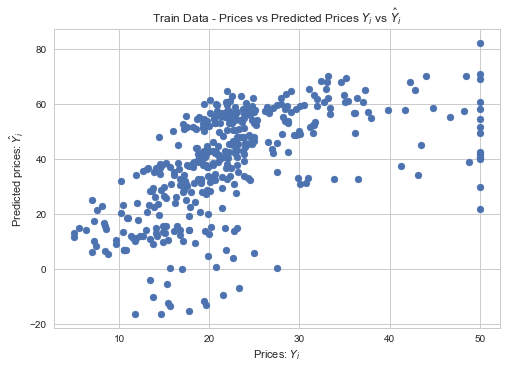

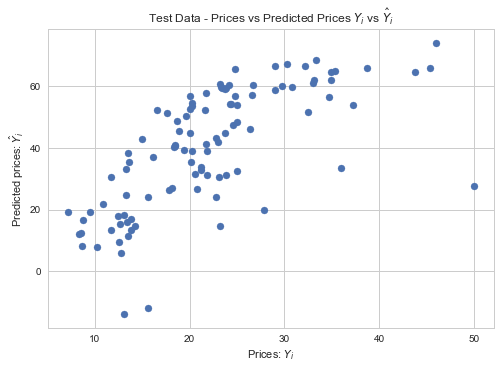

In [21]:
plot_graphs( X_train_final, y_train, X_test_final, y_test)    

### Plot residuals

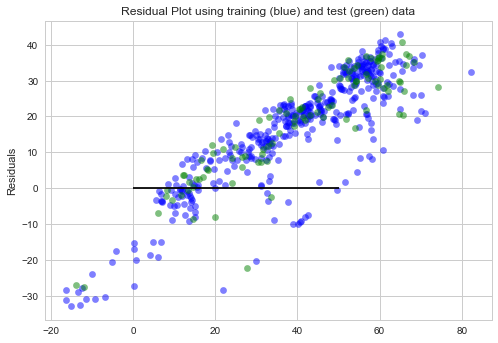

In [22]:
plot_residuals(X_train_final, y_train, X_test_final, y_test)

## Lasso 

### GridSearch + CV

In [23]:
lasso = Lasso(random_state=1)
parameters_lasso = {
    'alpha' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}
model_lasso = grid_search_model(X_train_final, y_train, lasso, parameters_lasso, 'neg_mean_squared_error', cv_kfold, 0 )
model_lasso

Best score: -25.4415596303
Best parameters: {'alpha': 0.01}
Find best parameterers in 0.1880 seconds.


Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)

In [24]:
results_folds = model_reg_cv(model_lasso,X_train_final, y_train, cv_kfold)
results_folds

,MAE: 1. Treino,MAE: 2. Teste,MSE: 1. Treino,MSE: 2. Teste,r2: 1. Treino,r2: 2. Teste
0,3.107080,3.933563,19.693236,34.600353,0.777239,0.550724
1,3.537235,2.853161,24.537364,14.131138,0.731696,0.782130
2,3.399245,3.343445,22.736313,22.734793,0.726303,0.763581
3,3.386434,3.209930,24.033524,15.952523,0.708544,0.839414
4,3.035170,4.162548,18.678946,39.968334,0.780350,0.557778
mean,3.293033,3.500529,21.935876,25.477428,0.744826,0.698725


In [25]:
model_reg_holdout(model_lasso,X_train_final, y_train, X_test_final, y_test)

,1. Treino,2. Teste
MSE,22.278490,20.674163
MAE,3.303403,3.289600
R2,0.741314,0.732973


auxiliar -> grid search retorna valores da base de treino caso necessário

In [27]:
parameters_lasso = {
    'alpha' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}
grid_obj = GridSearchCV(lasso, parameters_lasso, scoring = 'neg_mean_squared_error', cv=cv_kfold, return_train_score=True , verbose = 3)
grid_fit = grid_obj.fit(X_train_final, y_train)
cv_results = grid_fit.cv_results_
cv_results = pd.DataFrame(cv_results)

#cv_results2 = cv_results[[ u'param_alpha', u'split0_test_score', u'split0_train_score', u'split1_test_score',
#       u'split1_train_score', u'split2_test_score', u'split2_train_score',
#       u'split3_test_score', u'split3_train_score', u'split4_test_score',
#       u'split4_train_score', u'mean_test_score', u'mean_train_score' ]]
cv_results

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] alpha=0.001 .....................................................
[CV] .................... alpha=0.001, score=-34.422022, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] .................... alpha=0.001, score=-14.328489, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] .................... alpha=0.001, score=-22.897358, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] .................... alpha=0.001, score=-15.974355, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] .................... alpha=0.001, score=-39.923943, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] ..................... alpha=0.01, score=-34.600353, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] ............

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.1s finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.0020,0.0004,-25.473554,-21.930140,0.001,{u'alpha': 0.001},2,-34.422022,-19.688382,-14.328489,...,-22.897358,-22.731738,-15.974355,-24.027336,-39.923943,-18.672866,6.324851e-04,0.00049,10.086138,2.342534
1,0.0014,0.0002,-25.441560,-21.935876,0.01,{u'alpha': 0.01},1,-34.600353,-19.693236,-14.131138,...,-22.734793,-22.736313,-15.952523,-24.033524,-39.968334,-18.678946,4.898430e-04,0.00040,10.187057,2.342887
2,0.0028,0.0018,-25.770847,-22.395888,0.1,{u'alpha': 0.1},3,-36.935718,-20.137933,-12.940945,...,-21.525315,-23.151991,-16.496990,-24.485645,-41.145070,-19.169010,7.483282e-04,0.00160,11.209725,2.341541
3,0.0010,0.0006,-30.627764,-28.836319,1,{u'alpha': 1},4,-40.456453,-25.105988,-15.650149,...,-25.813975,-31.051798,-25.148682,-30.960409,-46.262583,-24.372286,0.000000e+00,0.00049,11.109260,3.409473
4,0.0012,0.0002,-86.450105,-86.085864,10,{u'alpha': 10},5,-77.017240,-88.405042,-64.860667,...,-98.818487,-83.071186,-101.069361,-82.460174,-90.535202,-85.039498,4.000664e-04,0.00040,13.715588,3.391697
5,0.0016,0.0002,-86.450105,-86.085864,100,{u'alpha': 100},5,-77.017240,-88.405042,-64.860667,...,-98.818487,-83.071186,-101.069361,-82.460174,-90.535202,-85.039498,4.898819e-04,0.00040,13.715588,3.391697
6,0.0010,0.0002,-86.450105,-86.085864,1000,{u'alpha': 1000},5,-77.017240,-88.405042,-64.860667,...,-98.818487,-83.071186,-101.069361,-82.460174,-90.535202,-85.039498,1.168008e-07,0.00040,13.715588,3.391697


## KNN

In [28]:
from sklearn.neighbors import KNeighborsRegressor

In [29]:
knn = KNeighborsRegressor()
#cv = KFold(5, random_state=1, shuffle=True)

parameters_knn = {
    'n_neighbors' : [1, 2,3,4,5]
}
model_knn = grid_search_model(X_train_final, y_train, knn, parameters_knn, 'neg_mean_squared_error', cv_loo, 0 )
model_knn

Best score: -17.5085726073
Best parameters: {'n_neighbors': 3}
Find best parameterers in 17.2160 seconds.


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=3, p=2,
          weights='uniform')

In [31]:
results_folds = model_reg_cv(model_knn,X_train_final, y_train, cv_loo)
results_folds

,MAE: 1. Treino,MAE: 2. Teste,MSE: 1. Treino,MSE: 2. Teste,r2: 1. Treino,r2: 2. Teste
0,1.825310,0.066667,8.398462,0.004444,0.902681,0.0
1,1.824483,0.400000,8.397497,0.160000,0.902716,0.0
2,1.813234,1.466667,8.351839,2.151111,0.903116,0.0
3,1.818280,6.600000,8.373248,43.560000,0.902872,0.0
4,1.825641,0.400000,8.401963,0.160000,0.902669,0.0
5,1.818280,2.500000,8.384160,6.250000,0.902879,0.0
6,1.802399,13.500000,8.205109,182.250000,0.904898,0.0
7,1.816708,4.733333,8.349043,22.404444,0.903213,0.0
8,1.819686,0.866667,8.387786,0.751111,0.902432,0.0
9,1.820265,2.300000,8.390915,5.290000,0.902367,0.0


In [32]:
model_reg_holdout(model_knn,X_train_final, y_train, X_test_final, y_test)

,1. Treino,2. Teste
MSE,8.376482,20.941089
MAE,1.819719,2.654902
R2,0.902737,0.729526


## Ridge

In [33]:
ridge = Ridge(random_state=11)
parameters_ridge = {
    'alpha' : [0.001,0.05, 0.01,0.1, 1,10]
}
model_ridge = grid_search_model(X_train_final, y_train, ridge, parameters_ridge, 'neg_mean_squared_error', cv_kfold, 0)
model_ridge

Best score: -25.3741954963
Best parameters: {'alpha': 10}
Find best parameterers in 0.1900 seconds.


Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=11, solver='auto', tol=0.001)

In [34]:
results_folds = model_reg_cv(model_ridge,X_train_final, y_train, cv_kfold)
results_folds

,MAE: 1. Treino,MAE: 2. Teste,MSE: 1. Treino,MSE: 2. Teste,r2: 1. Treino,r2: 2. Teste
0,3.079442,3.934562,19.789770,35.164836,0.776147,0.543394
1,3.502376,2.746600,24.725317,13.318079,0.729640,0.794666
2,3.351275,3.279862,22.902078,22.190089,0.724308,0.769245
3,3.350367,3.162952,24.184646,16.018553,0.706711,0.838750
4,3.017190,4.113241,18.783001,40.364485,0.779126,0.553395
mean,3.260130,3.447443,22.076962,25.411209,0.743186,0.699890


In [35]:
model_reg_holdout(model_ridge, X_train_final, y_train, X_test_final, y_test)

,1. Treino,2. Teste
MSE,22.371220,20.653447
MAE,3.274133,3.271483
R2,0.740237,0.733241
